In [107]:
import cv2
import os
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 180

plt.rcParams['figure.constrained_layout.use'] = True


In [152]:
IMG_DIR = 'panorama_images'

files = list(map(lambda x: os.path.join(IMG_DIR, x), os.listdir(IMG_DIR)))
files.sort()
files

['panorama_images/1.jpg',
 'panorama_images/2.jpg',
 'panorama_images/3.jpg',
 'panorama_images/4.jpg']

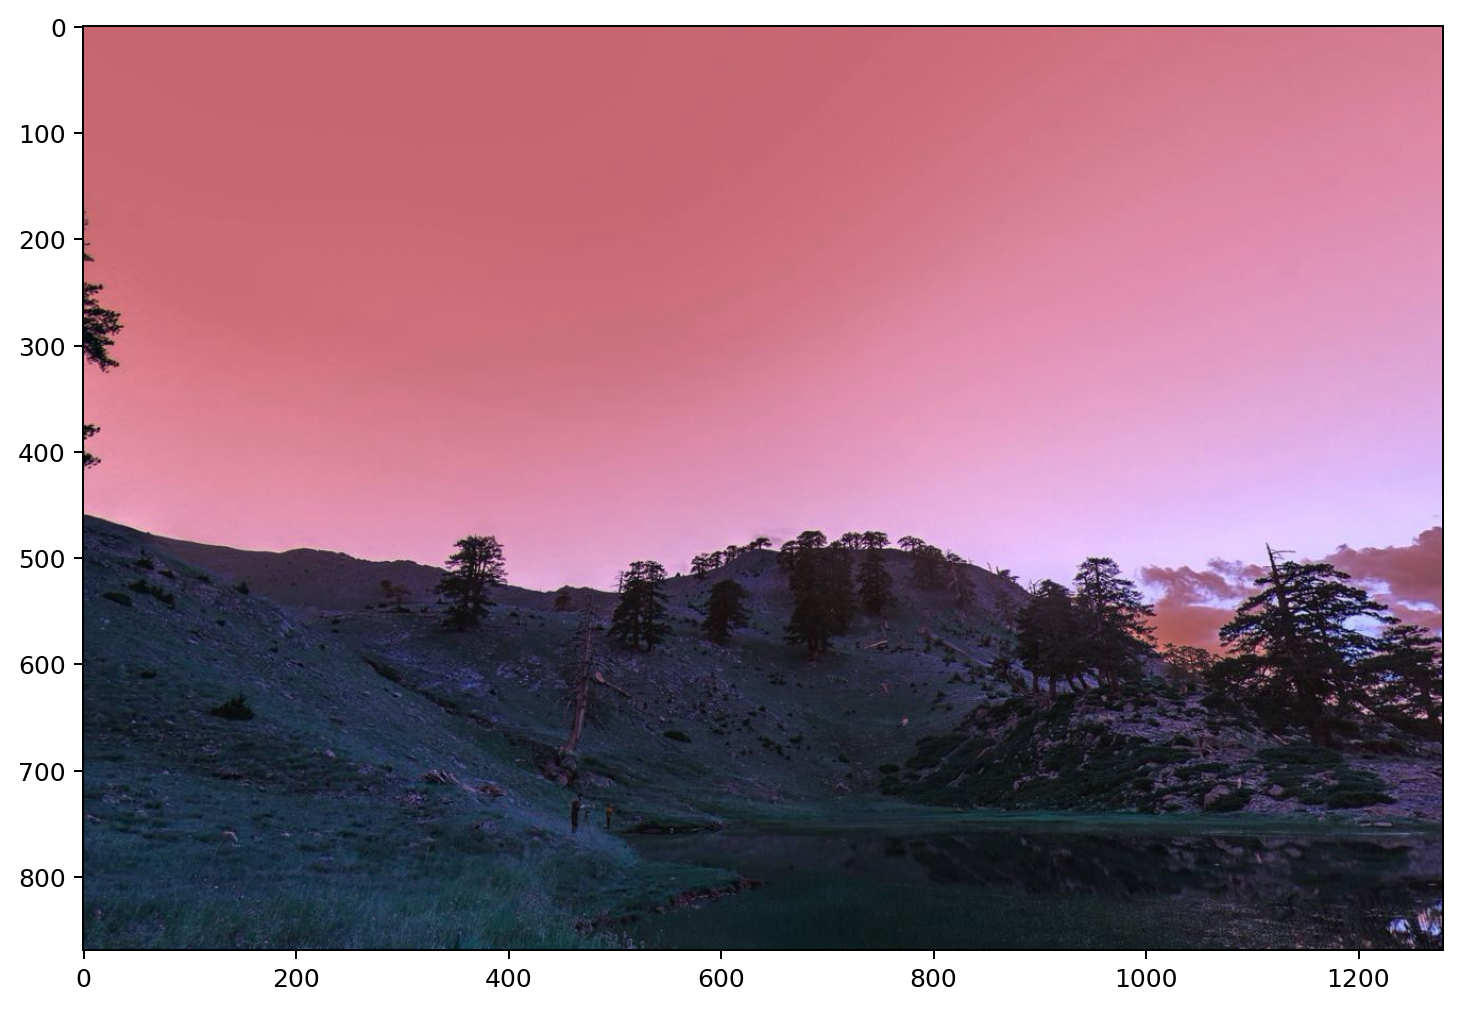

In [153]:
images = []
for filename in files:
    images.append(cv2.imread(filename))
        
plt.imshow(images[0])

In [56]:
sift = cv2.xfeatures2d.SIFT_create()

keypoints, desc = sift.detectAndCompute(images[0], None)
keypoints[0], desc.shape

(<KeyPoint 0x1323bc4e0>, (1968, 128))

In [57]:
drawn_keypoints_img = cv2.drawKeypoints(images[0], keypoints, None)

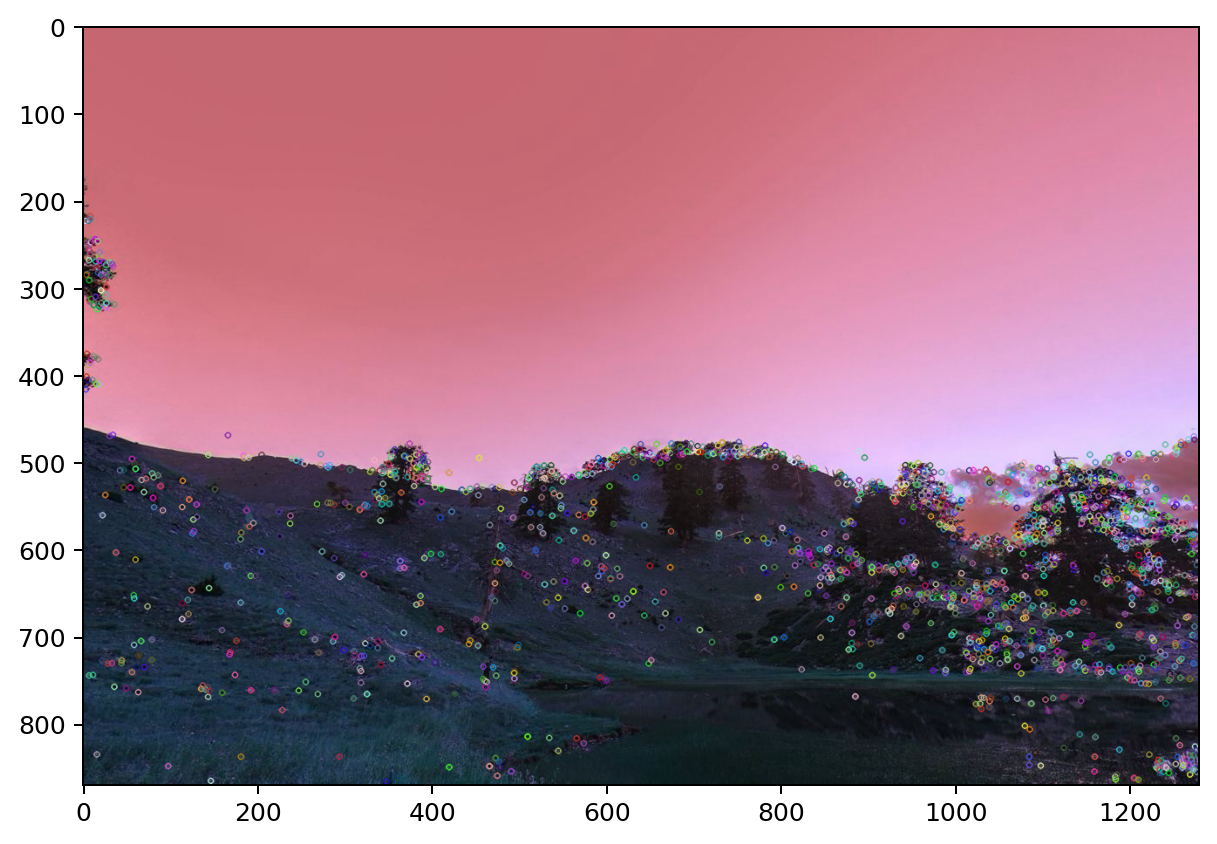

In [58]:
plt.imshow(drawn_keypoints_img)

### Get keypoints and descriptions from all images

In [59]:
kd = []
for image in images:
    kd.append(sift.detectAndCompute(image, None))

In [60]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

In [61]:
matches = bf.match(kd[0][1], kd[1][1])

In [97]:
matched_image = cv2.drawMatches(images[0], kd[0][0],
                                images[1], kd[1][0],
                                matches[:100], None)

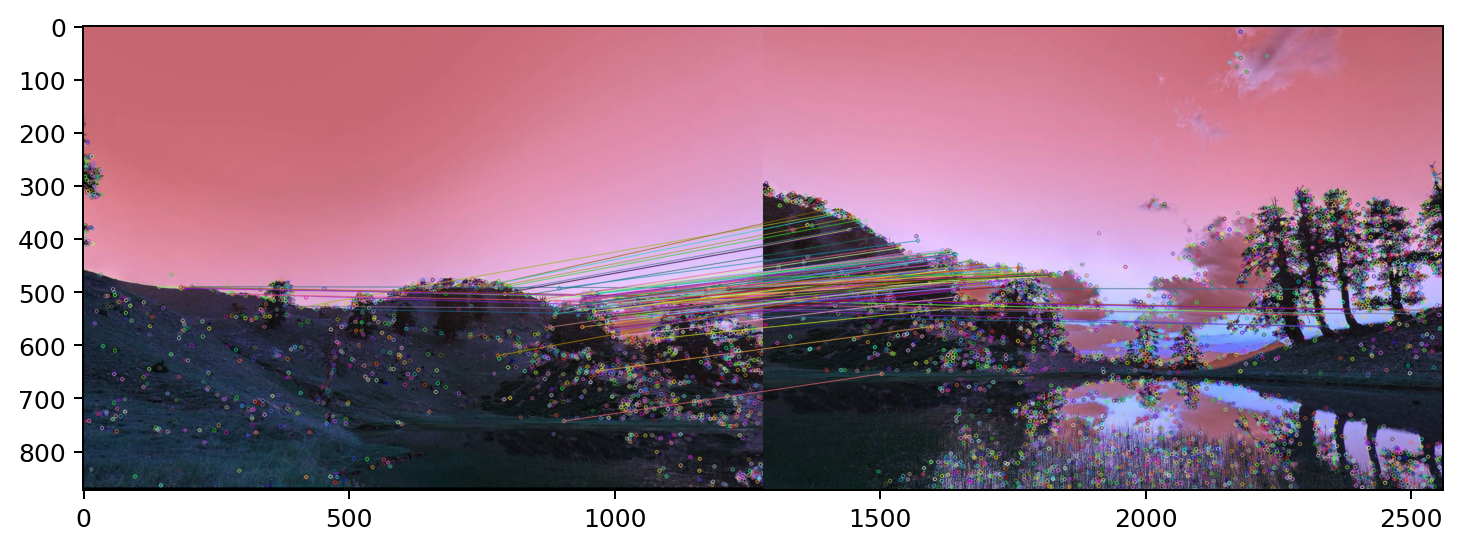

In [98]:
plt.imshow(matched_image)

### Find the homography matrix and warp the images

In [166]:
image_a, image_b = images[1], images[0]
image_b.resize(image_a.shape, refcheck=False)

kps_a, dsc_a = sift.detectAndCompute(image_a, None)
kps_b, dsc_b = sift.detectAndCompute(image_b, None)

kps_a, kps_b = np.float32([kp.pt for kp in kps_a]), np.float32([kp.pt for kp in kps_b])

In [167]:
knn_matcher = cv2.DescriptorMatcher_create('BruteForce')
knn_matches = knn_matcher.knnMatch(dsc_a, dsc_b, 2)

In [168]:
image_a.shape, image_b.shape

((869, 1280, 3), (869, 1280, 3))

In [169]:
matches = []
for m in knn_matches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
        matches.append((m[0].trainIdx, m[0].queryIdx))

In [170]:
len(matches)

483

In [171]:
pts_a = np.float32([kps_a[i] for (_, i) in matches])
pts_b = np.float32([kps_b[i] for (i, _) in matches])

h_matrix, _ = cv2.findHomography(pts_a, pts_b, cv2.RANSAC, 4.0)
h_matrix

array([[-5.55206730e-02, -5.08667682e-03,  6.45356207e+02],
       [-5.31060275e-01,  5.30697098e-01,  2.87862824e+02],
       [-7.27946623e-04, -2.17601299e-04,  1.00000000e+00]])

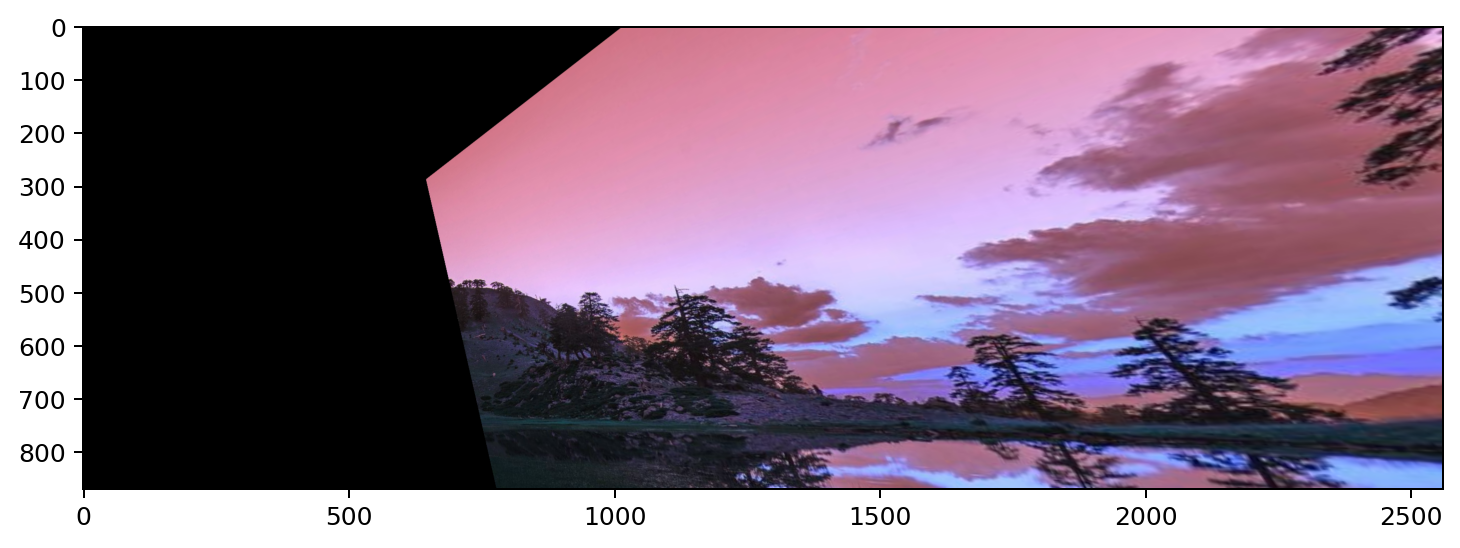

In [174]:
result_image = cv2.warpPerspective(image_a, h_matrix,
                                  (image_a.shape[1] + image_b.shape[1], image_a.shape[0]))

plt.imshow(result_image)

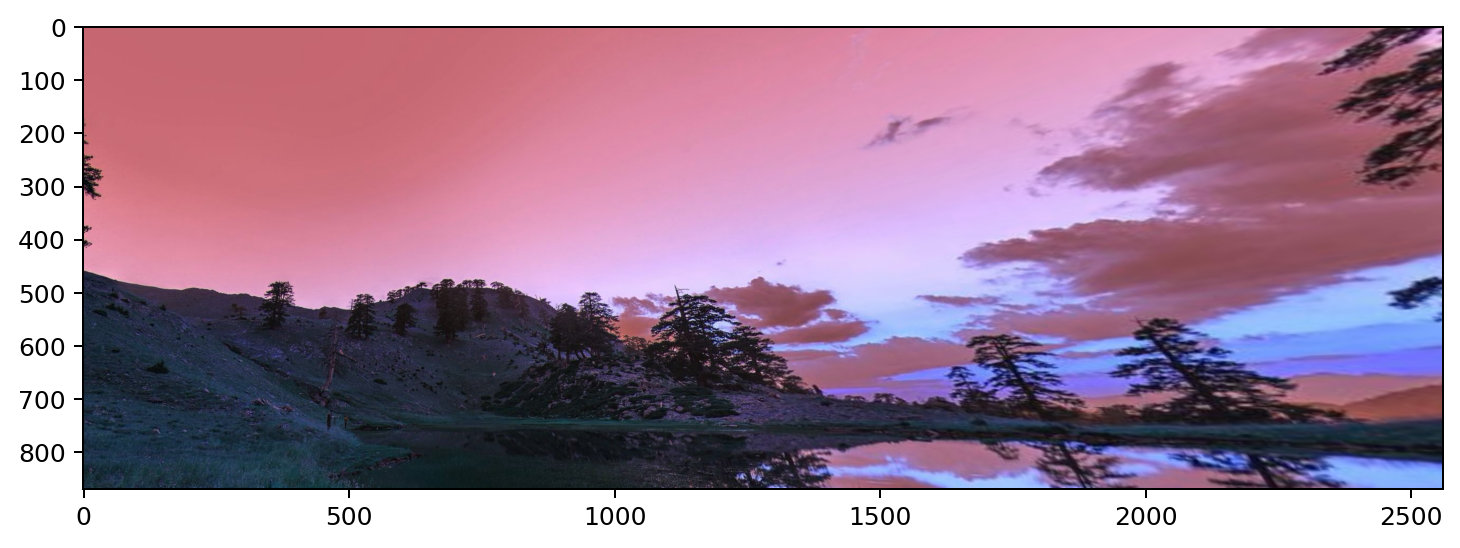

In [173]:
result_image[0:image_b.shape[0], 0:image_b.shape[1]] = image_b
plt.imshow(result_image)